In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Homework part I: Prohibited Comment Classification (10 points)

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this notebook__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [3]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [4]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

In [5]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [6]:
for i in range(texts_train.size):
    texts_train[i] = preprocess(texts_train[i])

In [7]:
for i in range(texts_test.size):
    texts_test[i] = preprocess(texts_test[i])

In [13]:
texts_train[5]

texts_test[89]

'who cares anymore . they attack with impunity .'

In [ ]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .' #????
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. Please don't do that in the current assignment, though.
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [94]:
#!!!!!!!!!!!!!!!
from collections import Counter
k = 10000
n
counter = Counter()
for text in texts_train:
    tokens = text.split()
    counter.update(tokens)

most_common_tokens = counter.most_common(k)

bow_vocabulary = [token for token, _ in most_common_tokens]
print('example features:', sorted(bow_vocabulary)[::322])

example features: ['!', 'abstain', 'assad', 'business', 'consistent', 'died', 'evident', 'gave', 'humans', 'killings', 'mei', 'observer', 'pov', 'remotely', 'shootings', 'sucking', 'trojan', 'whirling']


In [15]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    token_counts = Counter(text.split())
    
    bow_array = [token_counts[token] if token in bow_vocabulary else 0 for token in bow_vocabulary]
    
    return np.array(bow_array, dtype='float32')

In [16]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [23]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

__Naive bayes:__ perhaps the simplest model that can solve your problem is the so called Naive Bayes Classifier. 
Its a trivial linear model that assumes the independence of input features and computes the coefficients by, well, counting probabilities.

If you don't remember the math behind Naive Bayes, read [this chunk](https://lena-voita.github.io/nlp_course/text_classification.html#naive_bayes) to help refresh your memory. Done? Good! Now let's implement that :)

In [48]:
class BinaryNaiveBayes:
    delta = 1.0

    def fit(self, X, y):
        self.p_y = np.array([(y == 0).mean(), (y == 1).mean()])


        word_counts_positive = X[y == 1].sum(axis=0)
        word_counts_negative = X[y == 0].sum(axis=0)

        self.p_x_given_positive = (word_counts_positive + self.delta) / (word_counts_positive.sum() + self.delta * X.shape[1])
        self.p_x_given_negative = (word_counts_negative + self.delta) / (word_counts_negative.sum() + self.delta * X.shape[1])

        return self

    def predict_scores(self, X):
        log_p_x_given_positive = np.log(self.p_x_given_positive)
        log_p_x_given_negative = np.log(self.p_x_given_negative)

        score_positive = X.dot(log_p_x_given_positive) + np.log(self.p_y[1])
        score_negative = X.dot(log_p_x_given_negative) + np.log(self.p_y[0])
        
        return np.stack([score_negative, score_positive], axis=-1)

    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)


In [49]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [50]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

f_index = bow_vocabulary.index('fuck')
assert naive_model.p_x_given_positive[f_index] > naive_model.p_x_given_negative[f_index]

g_index = bow_vocabulary.index('good')
assert naive_model.p_x_given_positive[g_index] < naive_model.p_x_given_negative[g_index]

Model accuracy: 0.756
Well done!


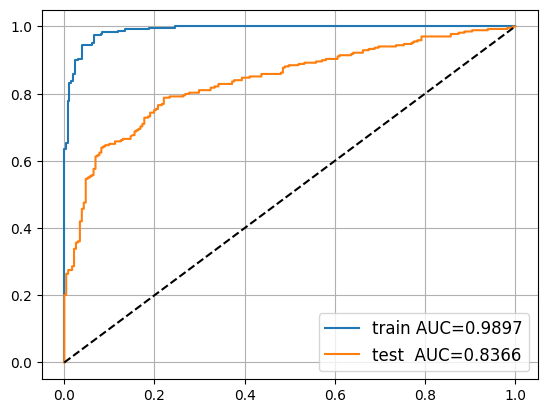

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

Okay, it definitely learned *something*. Now let's figure out what exactly it learned. The simplest way to do that is by highlighting which words have a greatest ratio of positive to negative probability or vice versa. We'll go with the positive one [because reasons](https://www.urbandictionary.com/define.php?term=because%20reasons).

__Your task__ is to compute top-25 words that have the __highest__ ratio of ${p(x_i | y=1)} \over {p(x_i | y=0)}$. Enjoy!

In [95]:
for i, idx in enumerate(np.argsort(probability_ratio)[-25:][::-1]):
    word = bow_vocabulary[idx]
    ratio = probability_ratio[idx]
    print(f"#{i+1}\t{word}\t{ratio:.6f}")


#1	hitler	475.472107
#2	heil	471.805176
#3	offfuck	441.247864
#4	suck	314.740936
#5	nigger	223.679657
#6	j.delanoy	220.012787
#7	dick	187.010864
#8	fggt	97.783463
#9	bitch	59.892372
#10	fuck	53.780903
#11	shit	44.002556
#12	slap	44.002556
#13	fucking	31.779625
#14	ass	26.890451
#15	stupid	18.334398
#16	=	17.539955
#17	*	17.112106
#18	college	17.112106
#19	asshole	15.889812
#20	u	15.278687
#21	bastard	14.667520
#22	hit	14.667520
#23	idiot	13.445226
#24	@	13.445226
#25	scientific	12.222933


In [60]:
if 'j.delanoy' in bow_vocabulary:
    print(probability_ratio[bow_vocabulary.index('j.delanoy')])
if 'college' in bow_vocabulary:
    print(probability_ratio[bow_vocabulary.index('college')])


220.01279
17.112106


In [62]:
probability_ratio =  (naive_model.p_x_given_positive) / (naive_model.p_x_given_negative + 0.0000000001)

indices_sorted = np.argsort(probability_ratio)[-25:][::-1]
top_negative_words = [bow_vocabulary[i] for i in indices_sorted]

assert len(top_negative_words) == 25 and all(isinstance(w, str) for w in top_negative_words)
assert 'j.delanoy' in top_negative_words and 'college' in top_negative_words

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[bow_vocabulary.index(word)]:.6f})")

#0	    hitler	(ratio=475.472107)
#1	      heil	(ratio=471.805176)
#2	   offfuck	(ratio=441.247864)
#3	      suck	(ratio=314.740936)
#4	    nigger	(ratio=223.679657)
#5	 j.delanoy	(ratio=220.012787)
#6	      dick	(ratio=187.010864)
#7	      fggt	(ratio=97.783463)
#8	     bitch	(ratio=59.892372)
#9	      fuck	(ratio=53.780903)
#10	      shit	(ratio=44.002556)
#11	      slap	(ratio=44.002556)
#12	   fucking	(ratio=31.779625)
#13	       ass	(ratio=26.890451)
#14	    stupid	(ratio=18.334398)
#15	         =	(ratio=17.539955)
#16	         *	(ratio=17.112106)
#17	   college	(ratio=17.112106)
#18	   asshole	(ratio=15.889812)
#19	         u	(ratio=15.278687)
#20	   bastard	(ratio=14.667520)
#21	       hit	(ratio=14.667520)
#22	     idiot	(ratio=13.445226)
#23	         @	(ratio=13.445226)
#24	scientific	(ratio=12.222933)


Now lets try something less prehistoric: __Logistic Regression__. Turns out, if you're using silicon instead of an abacus, you can find model weights by optimizing the log-probability of the answer. Though, of course, you don't even need to write it by hand anymore. Let's sklearn it!

In [84]:
from sklearn.linear_model import LogisticRegression

bow_model = LogisticRegression(max_iter=1000, random_state=42, C = 0.2)

bow_model.fit(X_train_bow, y_train)

Test Accuracy: 0.772


Model accuracy: 0.772
Well done!


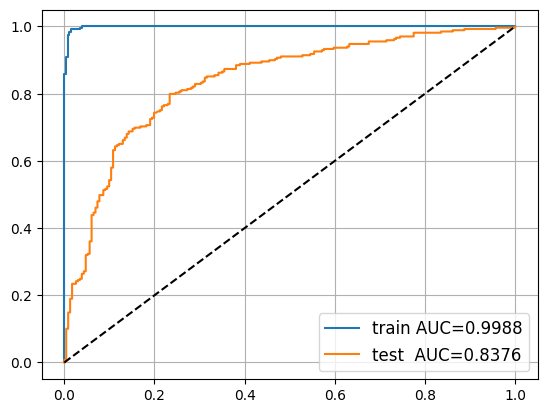

In [85]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ \text{feature}_i = \frac{\text{Count}(word_i \in x)}{\text{Total number of words in } x} \times \log\left(\frac{N}{\text{Count}(word_i \in D) + \alpha}\right) $$


, where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :) You can still use 'em for debugging though.

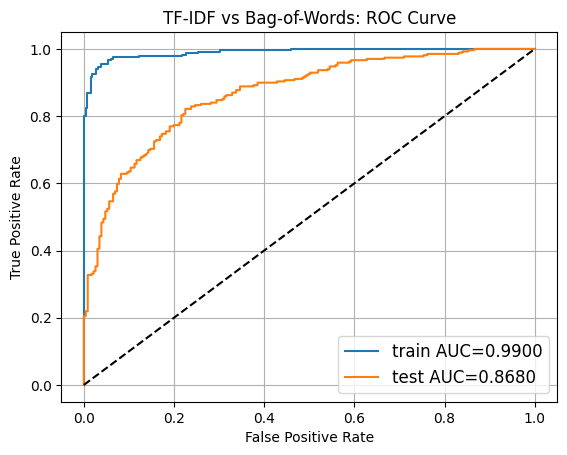

TF-IDF Model Accuracy: 0.776


In [86]:
def compute_tfidf(texts, vocabulary, smoothing=1):
    N = len(texts)  
    df = Counter()
    for text in texts:
        unique_words = set(text.split())
        for word in unique_words:
            if word in vocabulary:
                df[word] += 1


    idf = {
        word: np.log((N + smoothing) / (df[word] + smoothing))
        for word in vocabulary
    }

    tfidf_matrix = np.zeros((len(texts), len(vocabulary)), dtype=np.float32)
    for i, text in enumerate(texts):
        word_counts = Counter(text.split())
        total_terms = sum(word_counts.values())
        for j, word in enumerate(vocabulary):
            tf = word_counts[word] / total_terms if word in word_counts else 0
            tfidf_matrix[i, j] = tf * idf[word]

    norms = np.linalg.norm(tfidf_matrix, axis=1, keepdims=True)
    tfidf_matrix = tfidf_matrix / np.maximum(norms, 1e-10)

    return tfidf_matrix

tfidf_train = compute_tfidf(texts_train, bow_vocabulary)
tfidf_test = compute_tfidf(texts_test, bow_vocabulary)

tfidf_model = LogisticRegression(max_iter=1000, random_state=42)
tfidf_model.fit(tfidf_train, y_train)

for name, X, y, model in [
    ('train', tfidf_train, y_train, tfidf_model),
    ('test', tfidf_test, y_test, tfidf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black')
plt.title('TF-IDF vs Bag-of-Words: ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(fontsize='large')
plt.grid()
plt.show()


test_accuracy = np.mean(tfidf_model.predict(tfidf_test) == y_test)
print(f"TF-IDF Model Accuracy: {test_accuracy:.3f}")

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


### Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings
    * call `gensim.downloader.info()['models'].keys()` to get a list of available models
* clusterizing words by their word-vectors and try bag of cluster_ids

__Note:__ loading pre-trained model may take a while. It's a perfect opportunity to refill your cup of tea/coffee and grab some extra cookies. Or binge-watch some tv series if you're slow on internet connection

In [88]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

# If you're low on RAM or download speed, use "glove-wiki-gigaword-100" instead. Ignore all further asserts.

[==============------------------------------------] 28.8% 275.8/958.4MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 31.7% 304.1/958.4MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================================------------------] 64.0% 613.7/958.4MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 67.0% 642.1/958.4MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 958.5/958.4MB downloaded


In [89]:
def vectorize_sum(comment):
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')

    for token in comment.split():
        if token in embeddings:
            features += embeddings[token] 
    return features


assert np.allclose(
    vectorize_sum("who cares anymore . they attack with impunity .")[::70],
    np.array([0.0108616, 0.0261663, 0.13855131, -0.18510573, -0.46380025])
)

In [90]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

c:\users\nurtu\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


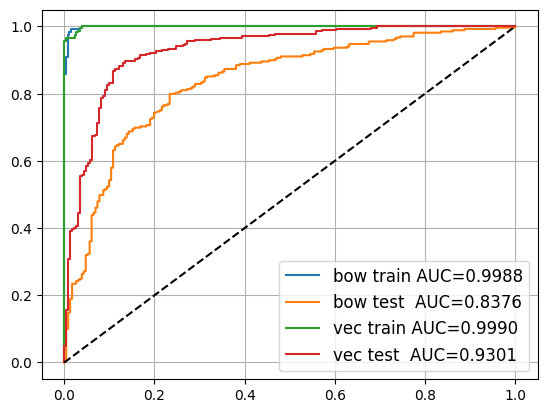

In [91]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

If everything went right, you've just managed to reduce misclassification rate by a factor of two.
This trick is very useful when you're dealing with small datasets. However, if you have hundreds of thousands of samples, there's a whole different range of methods for that. We'll get there in the second part.

### Homework part II: Salary prediction (10 points)
In this part, you will develop a deep learning model to predict salaries based on resumes. 

In this task, you are expected to conduct a more extensive study. This will involve testing various architectures to optimize prediction accuracy.

To secure full marks for this assignment, ensure a consistent training process with an MSE loss falling below 0.10. If necessary, feel free to experiment with different parameters and model architectures. 

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try all options from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)


#### Data: https://www.kaggle.com/c/job-salary-prediction/data (pick Train_rev1.*).

In [93]:
!kaggle competitions download -c job-salary-prediction

Traceback (most recent call last):
  File "C:\Users\nurtu\AppData\Local\Programs\Python\Python38\Scripts\kaggle-script.py", line 33, in <module>
    sys.exit(load_entry_point('kaggle==1.6.17', 'console_scripts', 'kaggle')())
  File "C:\Users\nurtu\AppData\Local\Programs\Python\Python38\Scripts\kaggle-script.py", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "c:\users\nurtu\appdata\local\programs\python\python38\lib\importlib\metadata.py", line 77, in load
    module = import_module(match.group('module'))
  File "c:\users\nurtu\appdata\local\programs\python\python38\lib\importlib\__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_import
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 961, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 219, in _call_with_fr

In [ ]:
# < A whole lot of your code > - models, charts, analysis

#### A) CNN architecture (3 points)

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling (1 points)

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

#### C) Fun with words (2 points)

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent (3 points)

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously (1 points)

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Happy New Year! And may the force be with you!